In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from dateutil.relativedelta import relativedelta

%matplotlib inline 

In [2]:
raw_data = pd.read_csv('Data_set.csv', parse_dates=['Date'],index_col=False)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5182659 entries, 0 to 5182658
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Date        datetime64[ns]
 1   Open        float64       
 2   High        float64       
 3   Low         float64       
 4   Close       float64       
 5   Adj Close   float64       
 6   Volume      float64       
 7   stock_name  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 316.3+ MB


In [3]:
raw_data.head()
# column_names=list(raw_data.columns)
# print(column_names)

,Date,Open,High,Low,Close,Adj Close,Volume,stock_name
0,2012-01-03,36.459999,36.709999,35.910000,36.029999,28.122219,3021500.0,ADI
1,2012-01-04,36.009998,36.080002,35.650002,35.980000,28.083200,1428000.0,ADI
2,2012-01-05,35.730000,36.220001,35.730000,36.139999,28.208084,2124300.0,ADI
3,2012-01-06,36.110001,36.220001,35.779999,35.900002,28.020756,3533000.0,ADI
4,2012-01-09,35.910000,36.689999,35.910000,36.599998,28.567129,2593900.0,ADI


In [4]:
df_2012_2017 = (
    raw_data
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.Date).dt.year))
    .query("year >= 2012")
    [['stock_name', 'Date', 'year', 'Open', 'Close']]
)
df_2012_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5182659 entries, 0 to 5182658
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   stock_name  object        
 1   Date        datetime64[ns]
 2   year        int64         
 3   Open        float64       
 4   Close       float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 237.2+ MB


In [5]:
first_date_list = [df_2012_2017.query("year == {}".format(2012+i)).Date.min() for i in range(11)]
last_date_list = [df_2012_2017.query("year == {}".format(2012+i)).Date.max() for i in range(11)]
first_date_df =pd.DataFrame({"Date": first_date_list}) 
last_date_df = pd.DataFrame({"Date": last_date_list})
first_date_df.head()

,Date
0,2012-01-03
1,2013-01-02
2,2014-01-02
3,2015-01-02
4,2016-01-04


In [6]:
# filtering for the first day data in `df_2012_2017`
first_date_2012_2017_df = (
    df_2012_2017
    .merge(first_date_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.Date).dt.year))
    .rename(columns={"Open": "open_first_day"})
    .reset_index(drop=True)
    [['stock_name', 'year', 'open_first_day']]
    .pivot_table(values='open_first_day', columns='year', index='stock_name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

# filtering last day data in `df_2012_2017` 
last_date_2012_2017_df = (
    df_2012_2017
    .merge(last_date_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.Date).dt.year))
    .rename(columns={"Close": "close_last_day"})
    .reset_index(drop=True)
    [['stock_name', 'year', 'close_last_day']]
    .pivot_table(values='close_last_day', columns='year', index='stock_name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)


In [7]:
last_date_2012_2017_df.head()

,stock_name,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,29.284693,40.90844,40.939999,41.810001,45.560001,66.970001,67.459999,85.309998,118.489998,159.649994,127.150002
1,AA,20.858040,25.54389,37.943371,23.717609,28.080000,53.869999,26.580000,21.510000,23.049999,59.580002,83.779999
2,AAL,13.500000,25.25000,53.630001,42.349998,46.689999,52.029999,32.110001,28.680000,15.770000,17.959999,19.690001
3,AAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.959999,24.650000,22.160000
4,AAOI,NaN,15.01000,11.220000,17.160000,23.440001,37.820000,15.430000,11.880000,8.510000,5.140000,2.990000


In [8]:
agg_first_date_df = (
    first_date_2012_2017_df
    .melt(id_vars='stock_name', value_vars=[ 2012+i for i in range(11)])
    .rename(columns={"variable": "year", "value": "open_first_day"})
)

agg_last_date_df = (
    last_date_2012_2017_df
    .melt(id_vars='stock_name', value_vars=[ 2012+i for i in range(11)])
    .rename(columns={"variable": "year", "value": "close_last_day"})
)

In [9]:
agg_last_date_df.head()

,stock_name,year,close_last_day
0,A,2012,29.284693
1,AA,2012,20.858040
2,AAL,2012,13.500000
3,AAN,2012,NaN
4,AAOI,2012,NaN


In [10]:
# calculating yearly return and then averaging them to get average yearly returns for each stock
agg_gains_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['stock_name', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    .groupby("stock_name")
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "avg_yearly_returns"})
)

# calculating overall variance using each year's return
agg_var_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['stock_name', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    [['stock_name', 'gains_pctg']]
    .groupby("stock_name")
    .agg(np.var)
    .reset_index()
    .rename(columns={"gains_pctg": "yearly_variance"})
)

agg_df3 = (
    agg_gains_df
    .merge(agg_var_df, on='stock_name', how='inner')
)
agg_df3.dropna(subset=["avg_yearly_returns", "yearly_variance"],inplace=True)
agg_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2109 entries, 0 to 2179
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stock_name          2109 non-null   object 
 1   avg_yearly_returns  2109 non-null   float64
 2   yearly_variance     2109 non-null   float64
dtypes: float64(2), object(1)
memory usage: 65.9+ KB


In [11]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [12]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

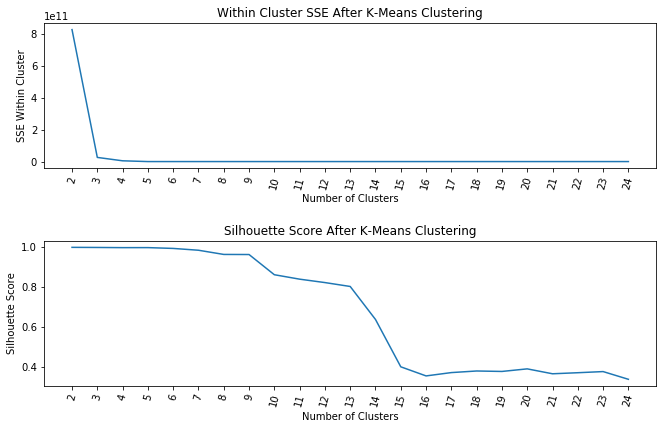

In [13]:
plot_cluster(agg_df3, max_loop=25)

In [14]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(round(score,2)))
    print("sse withing cluster: " + str(round(sse_within_cluster)))
    
    return df

In [15]:
first_trial = apply_cluster(agg_df3, clusters=13)

clustering performance
-----------------------------------
silhouette score: 0.8
sse withing cluster: 5584


In [16]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "stock_name":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

cluster_perf_df

,cluster,avg_yearly_returns,yearly_variance,stock_name
0,0,0.116321,1.433460e-01,1976
1,10,0.366434,1.533335e+00,100
2,9,0.782980,4.278687e+00,17
3,12,0.966773,9.127468e+00,4
4,7,1.231658,1.564718e+01,4
5,11,1.604588,2.617828e+01,1
6,8,1.764279,4.017366e+01,1
7,6,2.546452,6.602011e+01,1
8,5,5.788156,1.770676e+02,1
9,3,68.205099,2.339876e+04,1


In [18]:
# creating a dataframe that only consists of cluster `0`
agg_df3_sub = agg_df3.query("cluster == 0").reset_index(drop=True)

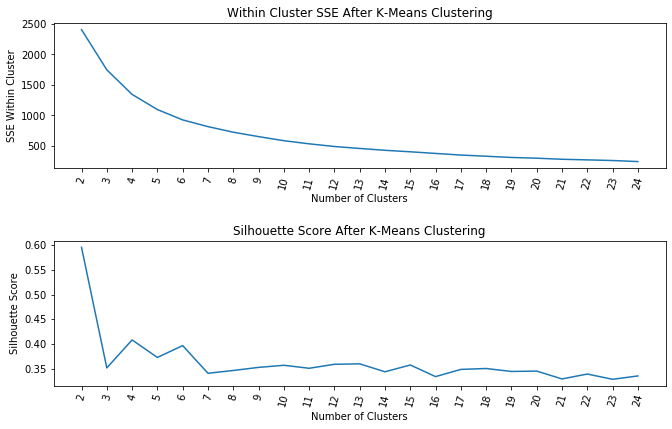

In [19]:
plot_cluster(agg_df3_sub, max_loop=25)

In [20]:
second_trial= apply_cluster(agg_df3_sub, clusters=6)

clustering performance
-----------------------------------
silhouette score: 0.4
sse withing cluster: 927


In [21]:
sub_cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "stock_name":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

sub_cluster_perf_df

,cluster,avg_yearly_returns,yearly_variance,stock_name
0,3,-0.194896,0.147079,90
1,0,0.061660,0.057921,806
2,1,0.067841,0.261709,213
3,4,0.192958,0.613058,103
4,2,0.193352,0.095554,637
5,5,0.316563,0.343099,127


In [22]:
print(len(second_trial.query("cluster == 2").stock_name.unique()))

637


In [23]:
# calculating the average risk free rate over the time period of 2012 - 2018 
us_yield_curve_5years_dict = {"year": [2012+i for i in range(11)],
                         "risk_free_rate": [0.89, 0.76, 1.72, 1.61, 1.73, 1.94, 2.25,2.49,1.69,0.38,1.37]}
us_yield_curve_5years_df = pd.DataFrame.from_dict(us_yield_curve_5years_dict)

avg_risk_free_rate = (
    us_yield_curve_5years_df
    .mean()
    [['risk_free_rate']]
    [0]
)

In [24]:
def get_sharpe_ratio_df(df):
    """
    Computing Sharpe Ratio
    """
    df_w_sharpe_ratio = (
        df
        .pipe(lambda x: x.assign(avg_risk_free_rate=avg_risk_free_rate/100))
        .pipe(lambda x: x.assign(std_dev=np.sqrt(x.yearly_variance)))
        .pipe(lambda x: x.assign(sharpe_ratio=(x.avg_yearly_returns-x.avg_risk_free_rate)/x.std_dev))
    )

    return df_w_sharpe_ratio

In [25]:
second_trial_w_sharpe_ratio = get_sharpe_ratio_df(second_trial)

In [26]:
def get_transform_df(df_w_sharpe_ratio):
    """
    Transforming dataframe so that I can plot a boxplot of `Returns`, `Variance` and `Sharpe Ratio` for each cluster
    """
    df_yearly_returns = (
        df_w_sharpe_ratio
        [['avg_yearly_returns', 'cluster']]
        .pipe(lambda x: x.assign(type='avg_yearly_returns'))
        .rename(columns={"avg_yearly_returns": "rate"})
    )

    df_variance = (
        df_w_sharpe_ratio
        [['yearly_variance', 'cluster']]
        .pipe(lambda x: x.assign(type='yearly_variance'))
        .rename(columns={"yearly_variance": "rate"})
    )

    df_sharpe_ratio = (
        df_w_sharpe_ratio
        [['sharpe_ratio', 'cluster']]
    )

    df_transform = pd.concat([df_yearly_returns, df_variance], axis=0)

    return df_transform, df_sharpe_ratio

In [27]:
sub_cluster_transform, sub_cluster_sharpe_ratio = get_transform_df(second_trial_w_sharpe_ratio)

In [28]:
def cluster_perf(transform_df, sharpe_ratio_df):
    """
    Plotting boxplot of cluster performance
    """
    _  = plt.figure(figsize=(15,7))

    ax1 = plt.subplot(121)
    _ = sns.boxplot(x='cluster', y='rate', hue='type', data=transform_df)
    _ = plt.title("Distribution of Returns and Variance for each Cluster")

    ax2 = plt.subplot(122)
    _ =sns.boxplot(x='cluster', y='sharpe_ratio', data=sharpe_ratio_df, color='royalblue')
    _ = plt.title("Distribution of Sharpe Ratio for each Cluster")

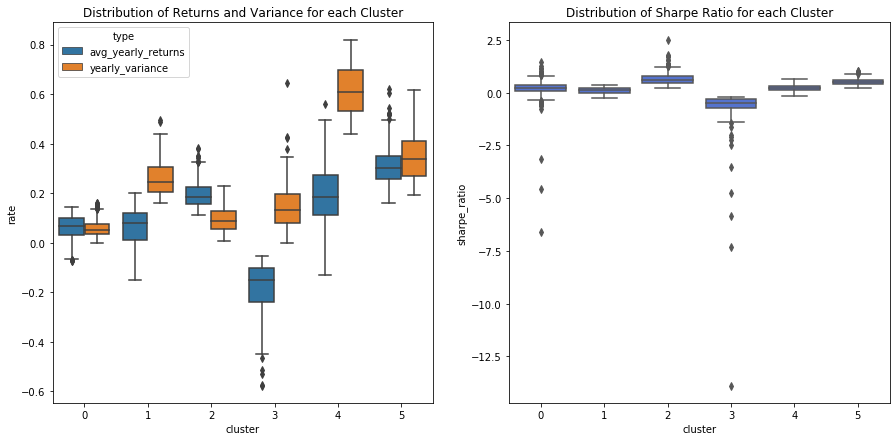

In [29]:
cluster_perf(sub_cluster_transform, sub_cluster_sharpe_ratio)

In [30]:
(
    second_trial_w_sharpe_ratio
    .groupby("cluster")
    .agg({"avg_yearly_returns": "mean", "yearly_variance": "mean", "sharpe_ratio": "mean", "stock_name": "count"})
    .reset_index()
)

,cluster,avg_yearly_returns,yearly_variance,sharpe_ratio,stock_name
0,0,0.061660,0.057921,NaN,806
1,1,0.067841,0.261709,0.106007,213
2,2,0.193352,0.095554,0.643273,637
3,3,-0.194896,0.147079,-0.964398,90
4,4,0.192958,0.613058,0.226277,103
5,5,0.316563,0.343099,0.528863,127


In [31]:
# filtering out for cluster 1
best_sub_cluster = second_trial.query("cluster == 2")

/tmp/ipykernel_19838/3546962165.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('cluster', axis=1, inplace=True)


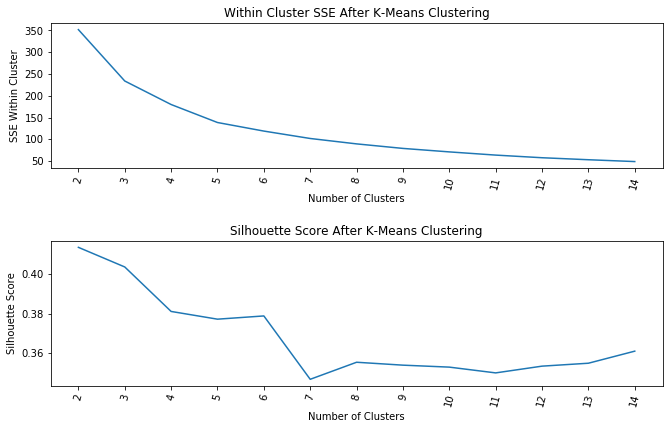

In [32]:
plot_cluster(best_sub_cluster, max_loop=15)

In [33]:
third_trial = apply_cluster(best_sub_cluster, clusters=6)

clustering performance
-----------------------------------
silhouette score: 0.38
sse withing cluster: 119


/tmp/ipykernel_19838/2824978611.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_


In [34]:
best_sub_cluster_perf = (    
    third_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "stock_name":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)
best_sub_cluster_perf

,cluster,avg_yearly_returns,yearly_variance,stock_name
0,2,0.144950,0.126702,112
1,0,0.163228,0.054984,219
2,4,0.205223,0.181695,63
3,1,0.215396,0.107468,100
4,5,0.227713,0.049949,79
5,3,0.292595,0.132755,64


In [35]:
third_trial_w_sharpe_ratio = get_sharpe_ratio_df(third_trial)

In [36]:
best_sub_cluster_transform, best_sub_cluster_sharpe_ratio = get_transform_df(third_trial_w_sharpe_ratio)

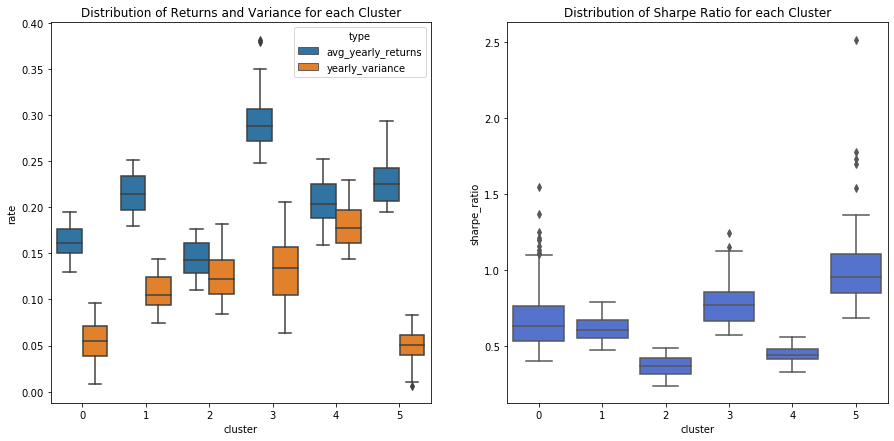

In [37]:
cluster_perf(best_sub_cluster_transform, best_sub_cluster_sharpe_ratio)

In [38]:
(
    third_trial_w_sharpe_ratio
    .groupby('cluster')
    .agg({"avg_yearly_returns": "mean", "yearly_variance": "mean", "sharpe_ratio": "mean", "stock_name": "count"})
    .reset_index()
)

,cluster,avg_yearly_returns,yearly_variance,sharpe_ratio,stock_name
0,0,0.163228,0.054984,0.678268,219
1,1,0.215396,0.107468,0.616334,100
2,2,0.144950,0.126702,0.369436,112
3,3,0.292595,0.132755,0.782357,64
4,4,0.205223,0.181695,0.447536,63
5,5,0.227713,0.049949,1.012007,79


In [39]:
third_trial.query("cluster == 5").stock_name.unique()

array(['ACN', 'ADSK', 'AET', 'AFAM', 'ANTM', 'AON', 'APH', 'AVY', 'AZO',
       'AZPN', 'BIO', 'BMI', 'BPOP', 'BR', 'CBZ', 'CHDN', 'CHE', 'CI',
       'COBZ', 'CONE', 'COST', 'CRL', 'CRM', 'CTAS', 'DELL', 'DHR', 'DPZ',
       'EFX', 'EXLS', 'EXPO', 'FISV', 'GOOG', 'GOOGL', 'HCA', 'HD', 'HEI',
       'HELE', 'IHC', 'INFO', 'INTU', 'IQV', 'LII', 'LLY', 'LOW', 'MA',
       'MCO', 'MLAB', 'MOH', 'MSCC', 'MSFG', 'MSFT', 'MTD', 'MUSA',
       'NDAQ', 'NOC', 'NSIT', 'ORLY', 'PF', 'PKI', 'PLUS', 'REXR', 'RMD',
       'SBAC', 'SCHW', 'SPGI', 'SSNC', 'STE', 'SWC', 'TDG', 'TDY', 'TECH',
       'TMO', 'TXN', 'ULTA', 'UNH', 'V', 'VRSN', 'WBCO', 'ZTS'],
      dtype=object)